In [45]:
import sys, os
sys.path.append('..')

from ML.Features import *
from ML.Targets import *
import numpy as np
import pandas as pd
import matplotlib

%matplotlib inline

from Data.TimeSeries import *
from Data.StockDataManager import  *


tickers = ['GOOG/AMEX_GSG']
# tickers = ['GOOG/NYSEARCA_GLD']

settings = Settings()
dp = TimeSeries(settings).get_ETF_data(tickers)
dp
df = dp[tickers[0]][['Open', 'High', 'Low', 'Close', 'volume']]
df = df[:'2016-01-01'].dropna()

In [47]:
def direction(df, histLen=1) :
    df_price = df[['Close']]
    df_dir = (df_price > df_price.shift(histLen)) * 1
    df_dir[:(histLen-1)] = np.nan
    return pd.DataFrame(data=df_dir.values, index=df.index, columns=['direction_{n}'.format(n=histLen)])


def target_direction(df, len=1) :
    df_dir = direction(df, len)
    df_dir = df_dir.shift(-1)
    return pd.DataFrame(data=df_dir.values, index=df.index, columns=['t_direction_{n}'.format(n=len)])

In [65]:
'''
Using the last N days price directions as the features
Target using the next day price direction
'''
def create_features(df, n = 5) :
    df_target = target_direction(df, 1)
    df_target.columns = ['target']
    
    list_df_features = []
    for i in xrange(n):
        list_df_features.append(direction(df, i+1))
    
    df_features = pd.DataFrame()
    for l in list_df_features:
        df_features = df_features.join(l, how='outer')
    df_features = df_features.join(df_target, how='outer')
    df_features.dropna(inplace=True)
    
    return df_features


data_split_ratio = 0.7


df_features = create_features(df, 10)
nr_training = int(data_split_ratio*len(df_features))

index_train = df_features.index[:nr_training]
index_test = df_features.index[(1+nr_training):]

df_train = df_features.loc[index_train]
df_test = df_features.loc[index_test]


n_feature_training = df_train.iloc[:, :-1].values
n_target_training = df_train.iloc[:, [-1]].values
n_feature_test = df_test.iloc[:, :-1].values
n_target_test = df_test.iloc[:, [-1]].values

error=0.474432


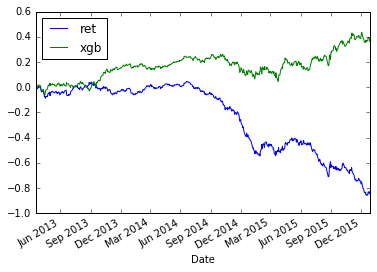

In [66]:
import xgboost as xgb


dtrain = xgb.DMatrix(df_train.iloc[:, :-1], label=df_train['target'].values)
dtest = xgb.DMatrix(df_test.iloc[:, :-1], label=df_test['target'].values)

# specify parameters via map, definition are same as c++ version
param = {'max_depth':2, 'eta':0.1, 'silent':1, 'objective':'binary:logistic' }

# specify validations set to watch performance
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = 200


bst = xgb.train(param, dtrain, num_boost_round=num_round)
# this is prediction
preds_xgb = bst.predict(dtest)
labels = dtest.get_label()
print ('error=%f' % ( sum(1 for i in range(len(preds_xgb)) 
                          if int(preds_xgb[i]>0.5)!=labels[i]) /float(len(preds_xgb))))
#xgb.plot_importanc

df_ret = pd.DataFrame()
df_ret['ret'] = np.log(df['Close']/df['Close'].shift(1))

df_ret = df_ret.loc[df_test.index, :]
df_ret['preds_xgb'] = preds_xgb

df_ret['xgb'] = df_ret['ret'] * (df_ret['preds_xgb'] > 0.5).shift(1) \
                 - df_ret['ret'] * (df_ret['preds_xgb'] < 0.5).shift(1)
df_ret[['ret','xgb']].cumsum().plot()

# Using KNN 

/Users/jianboxue/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


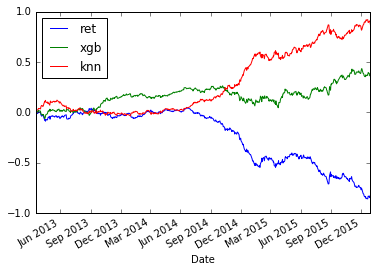

In [70]:
from sklearn import neighbors
k = 10

model_knn = neighbors.KNeighborsClassifier(k, 'distance')
model_knn.fit(n_feature_training,n_target_training)

preds_knn = model_knn.predict(n_feature_test)
df_preds_knn = pd.DataFrame(data=preds_knn, index=df_test.index, columns=['preds_knn'])

df_ret['preds_knn'] = df_preds_knn
df_ret['knn'] = df_ret['ret'] * (df_ret['preds_knn'] > 0.5).shift(1) \
                 - df_ret['ret'] * (df_ret['preds_knn'] < 0.5).shift(1)
df_ret[['ret','xgb', 'knn']].cumsum().plot()

/Users/jianboxue/anaconda/lib/python2.7/site-packages/sklearn/svm/base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


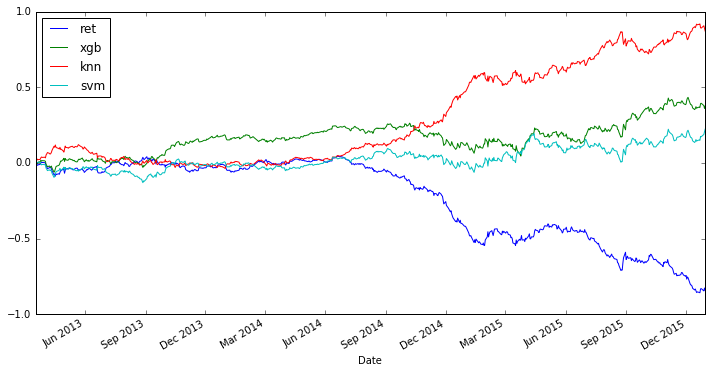

In [68]:
from sklearn import svm
model_svm = svm.SVC()
model_svm.fit(n_feature_training,n_target_training)

preds_svm = model_svm.predict(n_feature_test)
df_preds_svm = pd.DataFrame(data=preds_svm, index=df_test.index, columns=['preds_svm'])

df_ret['preds_svm'] = df_preds_svm
df_ret['svm'] = df_ret['ret'] * (df_ret['preds_svm'] > 0.5).shift(1) \
                 - df_ret['ret'] * (df_ret['preds_svm'] < 0.5).shift(1)
df_ret[['ret','xgb', 'knn', 'svm']].cumsum().plot(figsize=[12,6])

In [57]:
sector_tickers = ['GOOG/NYSE_SPY']

settings = Settings()
dp_sectors = TimeSeries(settings).get_agg_ETF_data(sector_tickers)
dp_sectors = dp_sectors.fillna(method='pad', axis=0)
dp_sectors = dp_sectors.fillna(method='bfill', axis=0)

from zipline.algorithm import TradingAlgorithm
from zipline.api import (add_history, history, set_slippage,
                         slippage, set_commission, commission,
                         order_target_percent, symbol,symbols)


def initialize(context):
        add_history(200, '1d', 'price')
        set_slippage(slippage.FixedSlippage(spread=0.0))
        set_commission(commission.PerShare(cost=0.01, min_trade_cost=1.0))
        context.tick = 0

def handle_data(context, data):
        training_window = 30
        nn_window = 5
        context.tick += 1
        
        if context.tick < (training_window + nn_window):
            return 
        
        price = history(training_window+nn_window, '1d', 'price').dropna()
        features = create_features(price, nn_window)
        
        print features.head()
        

        # momentum conditons
        prices_200d = history(200, '1d', 'price').dropna()
        prices_m = filtering(prices_200d, rebalance_period)
        prices_ma_10m = pd.rolling_mean(prices_m, 10)
        con1 = prices_m.tail(1) > prices_ma_10m.tail(1)
        
        # 
        #con2 = pd.rolling_sum(df_rets_m[t], moving_win) > pd.rolling_sum(df_rets_m[ticker_spy], moving_win)
        #con3 = pd.rolling_sum(df_rets_m[t], 1) > (0.05/6)
        
        # picking up the ETF, which outperforms the SPY
        moving_win = 3
        print prices_m.loc[:, ticker_spy]
        rets_3m = (prices_m / prices_m.shift(moving_win) - 1)
        rets_spy_3m = (prices_m[ticker_spy] / prices_m[ticker_spy].shift(moving_win) - 1)
        #print rets_3m

        # Get rolling window of past prices and compute returns
        prices_1d = history(1, '1d', 'price').dropna()
        prices_6m = history(120, '1d', 'price').dropna()
        returns_6m = prices_6m.pct_change().dropna()

        prices_200d = history(200, '1d', 'price').dropna()
        ma200 = np.mean(prices_200d)
        prices_60d = history(60, '1d', 'price').dropna()
        returns_60d = prices_60d.pct_change().dropna()

        try:
            # Get the strongest 5 in momentum

            mom = returns_6m.T.sum(axis=1)
            #selected_indices = mom[mom>0].order().tail(len(mom) /2).index
            selected_indices = prices_1d[prices_1d > ma200].value
            #selected_indices = mom[mom > 0 ].index
            selected_returns = returns_60d[selected_indices]

            weights = self.minimize_vol(selected_returns.T)
    #         weights = minimize_vol(returns_60d.T)
            # Rebalance portfolio accordingly
            for stock, weight in zip(selected_returns.columns, weights):
                order_target_percent(stock, weight)
        except :
            # Sometimes this error is thrown
            # ValueError: Rank(A) < p or Rank([P; A; G]) < n
            pass
        
        
algo_obj = TradingAlgorithm(initialize=initialize,
                            handle_data=handle_data)

# Run algorithm
perf_manual = algo_obj.run(dp_sectors)

KeyError: "['Close'] not in index"

In [350]:
dp_sectors

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 4689 (major_axis) x 6 (minor_axis)
Items axis: GOOG/NYSE_SPY to GOOG/NYSE_SPY
Major_axis axis: 1997-08-21 00:00:00+00:00 to 2016-03-22 00:00:00+00:00
Minor_axis axis: open to price